In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from config import *
from nerf import *
from camera_operations import *
from dataset import *

using device: cuda


c:\Users\Mathis\.conda\envs\ProjetTunnel\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, de

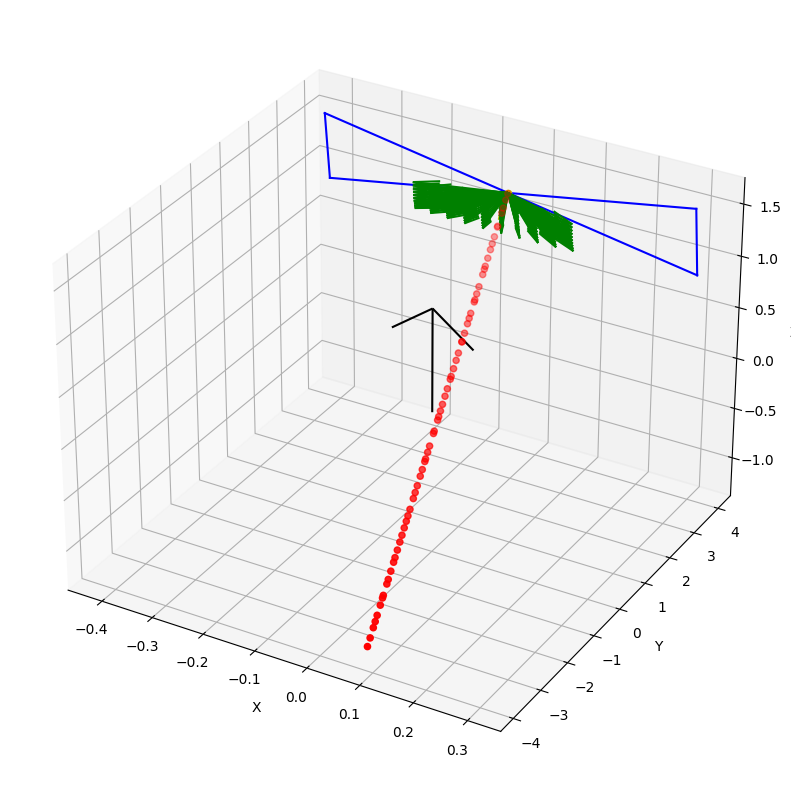

In [6]:
u, v = torch.meshgrid(torch.linspace(-image_height/2, image_width/2, image_height), torch.linspace(-image_width/2, image_width/2, image_width))
ds = extract_origin_and_direction(torch.Tensor(train_poses).to(device), u, v)[:,:,0,3:]


# 3D plot of the camera positions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(train_poses[:, 0, 3].cpu(), train_poses[:, 1, 3].cpu(), train_poses[:, 2, 3].cpu())
# for i in range(0, train_poses.shape[0]):
#     ax.quiver(train_poses[i, 0, 3].cpu(), train_poses[i, 1, 3].cpu(), train_poses[i, 2, 3].cpu(), -train_poses[i, 0, 2].cpu(), -train_poses[i, 1, 2].cpu(), -train_poses[i, 2, 2].cpu(), length=0.5, normalize=True, color='r')

# we now plot only the first camera pose, in yellow
ax.scatter(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), color='y')
ax.quiver(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), -train_poses[0, 0, 2].cpu(), -train_poses[0, 1, 2].cpu(), -train_poses[0, 2, 2].cpu(), length=0.5, normalize=True, color='y')


# black box at the origin for reference, length 1
ax.quiver(0, 0, 0, 0, 0, 1, length=1, normalize=True, color='k')

# for first camera pose, plot the image plane
# 4 corners of the image plane
dc = image_width / (2 * f)

corners = torch.tensor([[-dc, -dc, 0, 1], [-dc, dc, -0, 1], [dc, dc, -0, 1], [dc, -dc, -0, 1]], device = device, dtype = dtype)
corners = train_poses[0] @ corners.t()
corners = corners[:3] / corners[3]
corners = corners.t().cpu().numpy()
# connect the corners
ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], [corners[0, 2], corners[1, 2]], color='b')
ax.plot([corners[1, 0], corners[3, 0]], [corners[1, 1], corners[3, 1]], [corners[1, 2], corners[3, 2]], color='b')
ax.plot([corners[3, 0], corners[2, 0]], [corners[3, 1], corners[2, 1]], [corners[3, 2], corners[2, 2]], color='b')
ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], [corners[2, 2], corners[0, 2]], color='b')

# quiver plot of the pixel rays
for i in range(0, image_height, 10):
    for j in range(0, image_width, 10):
        ax.quiver(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), ds[i, j, 0].cpu(), ds[i, j, 1].cpu(), ds[i, j, 2].cpu(), length=0.5, normalize=True, color='g')

# plot a sample pixel ray
sampler = CoarseNeRFSampler(t_max=8)
ts = sampler.sample(train_poses[0, :3, 3], ds[50, 50])
xs = train_poses[0, :3, 3].cpu() + ds[50, 50].cpu() * ts[:, None].cpu()
xs = xs.cpu().numpy()
ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


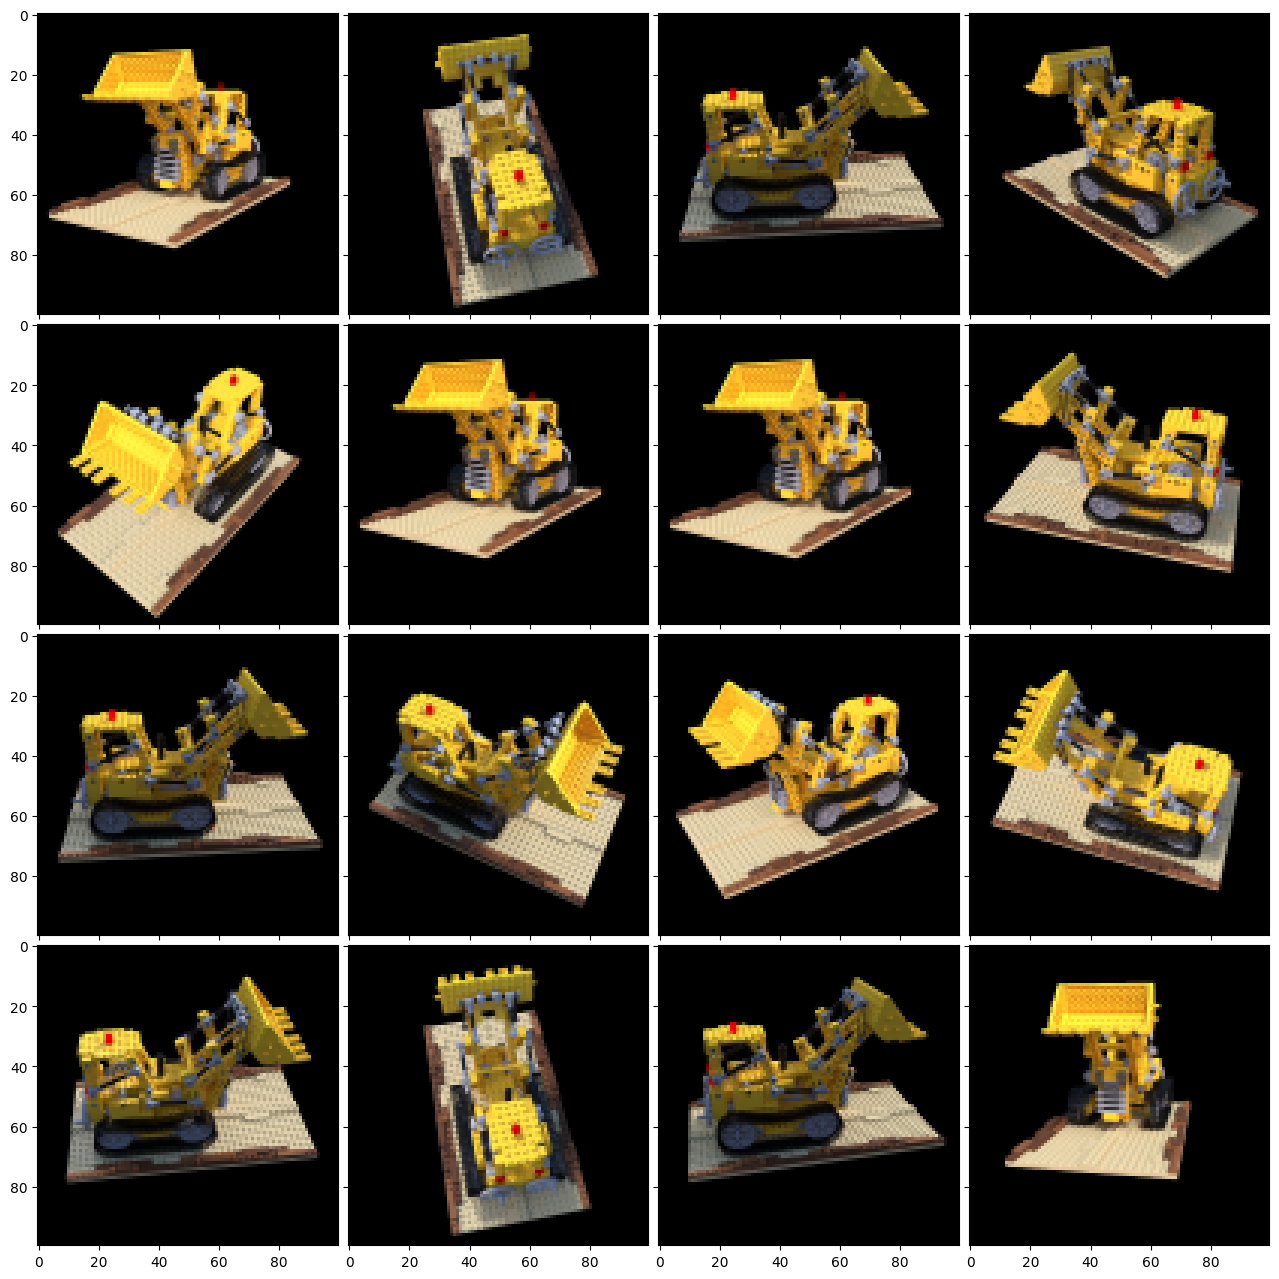

In [7]:
show_dataset()

In [16]:
coarse_sampler = CoarseNeRFSampler(t_min=0, t_max=8, Nc=64) 
coarse_model = NeRF(hidden_dim=128, sampler=coarse_sampler, name="coarse_128").to(device = device ,dtype=dtype)
coarse_model.train_model(train_poses, train_images) # saves the model each 5 epochs, automatically

Preprocessing ...
Training the model ...


C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, device = device, dtype = dtype)


Epoch 1/1000, Batch 1/160, Loss: 0.04597714408109543
Epoch 1/1000, Batch 101/160, Loss: 0.03360997644980151
Epoch 1/1000, Total Loss: 5.397651451267233
Saving model at epoch 0


RuntimeError: Parent directory models does not exist.

C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, device = device, dtype = dtype)


torch.Size([1, 3]) torch.Size([1, 3]) torch.Size([1, 65])
torch.Size([128])


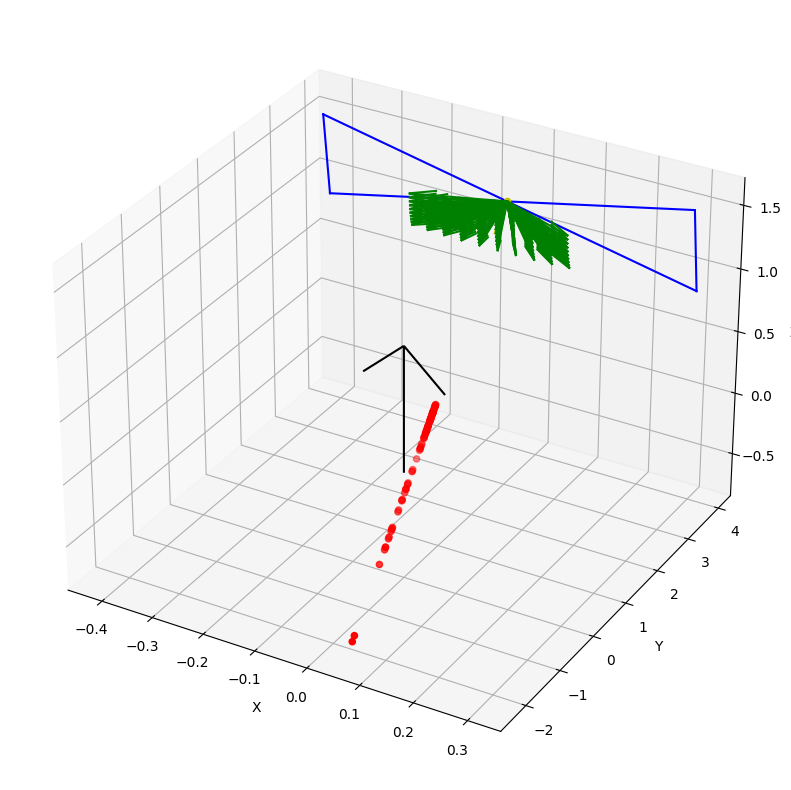

In [120]:
u, v = torch.meshgrid(torch.linspace(-image_height/2, image_width/2, image_height), torch.linspace(-image_width/2, image_width/2, image_width))
ds = extract_origin_and_direction(torch.Tensor(train_poses).to(device), u, v)[:,:,0,3:]
i = np.random.randint(0, train_poses.shape[0])

# 3D plot of the camera positions
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(train_poses[:, 0, 3].cpu(), train_poses[:, 1, 3].cpu(), train_poses[:, 2, 3].cpu())
# for i in range(0, train_poses.shape[0]):
#     ax.quiver(train_poses[i, 0, 3].cpu(), train_poses[i, 1, 3].cpu(), train_poses[i, 2, 3].cpu(), -train_poses[i, 0, 2].cpu(), -train_poses[i, 1, 2].cpu(), -train_poses[i, 2, 2].cpu(), length=0.5, normalize=True, color='r')

# we now plot only the first camera pose, in yellow
ax.scatter(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), color='y')
ax.quiver(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), -train_poses[0, 0, 2].cpu(), -train_poses[0, 1, 2].cpu(), -train_poses[0, 2, 2].cpu(), length=0.5, normalize=True, color='y')


# black box at the origin for reference, length 1
ax.quiver(0, 0, 0, 0, 0, 1, length=1, normalize=True, color='k')

# for first camera pose, plot the image plane
# 4 corners of the image plane
dc = image_width / (2 * f)

corners = torch.tensor([[-dc, -dc, 0, 1], [-dc, dc, -0, 1], [dc, dc, -0, 1], [dc, -dc, -0, 1]], device = device, dtype = dtype)
corners = train_poses[0] @ corners.t()
corners = corners[:3] / corners[3]
corners = corners.t().cpu().numpy()
# connect the corners
ax.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], [corners[0, 2], corners[1, 2]], color='b')
ax.plot([corners[1, 0], corners[3, 0]], [corners[1, 1], corners[3, 1]], [corners[1, 2], corners[3, 2]], color='b')
ax.plot([corners[3, 0], corners[2, 0]], [corners[3, 1], corners[2, 1]], [corners[3, 2], corners[2, 2]], color='b')
ax.plot([corners[2, 0], corners[0, 0]], [corners[2, 1], corners[0, 1]], [corners[2, 2], corners[0, 2]], color='b')

# quiver plot of the pixel rays
for i in range(0, image_height, 10):
    for j in range(0, image_width, 10):
        ax.quiver(train_poses[0, 0, 3].cpu(), train_poses[0, 1, 3].cpu(), train_poses[0, 2, 3].cpu(), ds[i, j, 0].cpu(), ds[i, j, 1].cpu(), ds[i, j, 2].cpu(), length=0.5, normalize=True, color='g')

# plot a sample pixel ray
sampler = FineNeRFSampler(model=coarse_model, t_max=8)
ts = sampler.sample(train_poses[0, :3, 3], ds[50, 50])
print(ts.shape)
xs = train_poses[0, :3, 3].cpu() + ds[50, 50].cpu() * ts[:, None].cpu()
xs = xs.detach().cpu().numpy()
ax.scatter(xs[:, 0], xs[:, 1], xs[:, 2], color='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


In [11]:
fine_sampler = NeRFSampler(coarse_model, Nf=128, Nc=64, t_min=0, t_max=8)
fine_model = NeRF(sampler=fine_sampler).to(device = device ,dtype=dtype)
fine_model.Nc = 128
fine_model.train_model(train_poses, train_images)

Preprocessing ...
Training the model ...


C:\Users\Mathis\AppData\Local\Temp\ipykernel_1372\3525372724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
C:\Users\Mathis\AppData\Local\Temp\ipykernel_1372\3525372724.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, device = device, dtype = dtype)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 635000 but got size 640000 for tensor number 1 in the list.

In [80]:
# load the coarse model from file
coarse_model = NeRF(hidden_dim=128, sampler=coarse_sampler, name="coarse_128").to(device = device ,dtype=dtype)
coarse_model.load_state_dict(torch.load("models/model_coarse_128_35.pt"))


<All keys matched successfully>

In [131]:
self_sampler = NeRFSampler(coarse_model, Nf=66, Nc=66, t_min=0, t_max=8)
self_model = NeRF(sampler=self_sampler, hidden_dim=128).to(device = device ,dtype=dtype)
self_model.load_state_dict(torch.load("models/model_coarse_128_35.pt"))

<All keys matched successfully>

In [133]:
# try to reconstruct the image from the validation pose
coarse_model.eval()
i = np.random.randint(0, len(train_poses))
predicted_image = coarse_model.predict_scene(train_poses[i])
predicted_image = predicted_image.detach().cpu().numpy()
predicted_image = predicted_image / np.max(predicted_image)
predicted_image = predicted_image
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(predicted_image)
plt.title("Predicted Image")

plt.subplot(1, 2, 2)
plt.imshow(train_images[i].cpu().numpy())
plt.title("Ground Truth Image")
plt.suptitle("Coarse Model Prediction, i = " + str(i))
plt.show()


C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, device = device, dtype = dtype)


OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 9.93 GiB is allocated by PyTorch, and 364.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [69]:
pip install pygame PyOpenGL PyOpenGL_accelerate


  Using cached PyOpenGL-3.1.7-py3-none-any.whl (2.4 MB)
     ---------------------------------------- 0.0/328.3 kB ? eta -:--:--
     -------------------------------------- 328.3/328.3 kB 9.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [79]:
import pygame
from pygame.locals import *
from OpenGL.GL import *
from OpenGL.GLU import *
import numpy as np

# Initialize Pygame and OpenGL
pygame.init()
display = (800, 600)
pygame.display.set_mode(display, DOUBLEBUF | OPENGL)
gluPerspective(45, (display[0] / display[1]), 0.1, 50.0)
glTranslatef(0.0, 0.0, -5)

# Define initial camera position and orientation
camera_pos = np.array([0.0, 0.0, 5.0])
camera_rot = np.array([0.0, 0.0, 0.0])

# Function to get the camera's position matrix
def get_camera_matrix():
    R = np.identity(3)
    t = camera_pos
    return np.array([[R[0,0], R[0,1], R[0,2], t[0]],
                     [R[1,0], R[1,1], R[1,2], t[1]],
                     [R[2,0], R[2,1], R[2,2], t[2]],
                     [0,       0,      0,      1]])

def draw_cube():
    glBegin(GL_QUADS)
    for surface in cube_surfaces:
        for vertex in surface:
            glVertex3fv(cube_vertices[vertex])
    glEnd()

# Function to convert the predicted image to a Pygame surface
def convert_to_surface(image_array):
    image_array = (image_array.detach().cpu().numpy() * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    image_surface = pygame.surfarray.make_surface(image_array)
    return pygame.transform.flip(pygame.transform.rotate(image_surface, -90), True, False)

# Define cube vertices and surfaces
cube_vertices = (
    (1, -1, -1),
    (1, 1, -1),
    (-1, 1, -1),
    (-1, -1, -1),
    (1, -1, 1),
    (1, 1, 1),
    (-1, -1, 1),
    (-1, 1, 1)
)

cube_surfaces = (
    (0, 1, 2, 3),
    (3, 2, 7, 6),
    (6, 7, 5, 4),
    (4, 5, 1, 0),
    (1, 5, 7, 2),
    (4, 0, 3, 6)
)

# Main loop
run = True
while run:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            run = False
    
    keys = pygame.key.get_pressed()
    if keys[pygame.K_LEFT]:
        camera_pos[0] -= 0.1
    if keys[pygame.K_RIGHT]:
        camera_pos[0] += 0.1
    if keys[pygame.K_UP]:
        camera_pos[1] += 0.1
    if keys[pygame.K_DOWN]:
        camera_pos[1] -= 0.1
    if keys[pygame.K_w]:
        camera_pos[2] -= 0.1
    if keys[pygame.K_s]:
        camera_pos[2] += 0.1
    if keys[pygame.K_a]:
        camera_rot[1] += 1.0
    if keys[pygame.K_d]:
        camera_rot[1] -= 1.0
    
    glLoadIdentity()
    glRotatef(camera_rot[0], 1, 0, 0)
    glRotatef(camera_rot[1], 0, 1, 0)
    glRotatef(camera_rot[2], 0, 0, 1)
    glTranslatef(-camera_pos[0], -camera_pos[1], -camera_pos[2])

    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    
    # Draw the cube (optional, for reference)
    draw_cube()

    # Get the updated camera matrix and predict the scene
    camera_matrix = get_camera_matrix()
    predicted_image = coarse_model.predict_scene(camera_matrix)

    # Convert the predicted image to a Pygame surface and display it
    image_surface = convert_to_surface(predicted_image)
    screen = pygame.display.get_surface()
    screen.blit(image_surface, (0, 0))

    pygame.display.flip()
    pygame.time.wait(10)

    print(camera_matrix)

pygame.quit()


C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u = torch.tensor(u, device = device, dtype = dtype)
C:\Users\Mathis\AppData\Local\Temp\ipykernel_24480\3525372724.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v, device = device, dtype = dtype)


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 5.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 5.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 5.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 5.]
 [0. 0. 0. 1.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 5.]
 [0. 0. 0. 1.]]
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -0.1]
 [ 0.   0.   1.   5. ]
 [ 0.   0.   0.   1. ]]
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.  -0.1]
 [ 0.   0.   1.   5. ]
 [ 0.   0.   0.   1. ]]


KeyboardInterrupt: 

In [52]:
first_part = coarse_model.branch1

# we try to get the sigma values for the first 100 rays
o = train_poses[0, :3, 3]
d = ds[50, 50][:, None]
t = coarse_model.sampler.sample(o, d)
print(d.shape, t.shape)
x = o[:, None] + d * t
x = x.reshape(-1, 3)
x = coarse_model.positional_encoding(x/8, coarse_model.Lx)
outputs = first_part(x)
outputs = outputs.reshape(-1, coarse_model.Nc, coarse_model.hidden_dim)
outputs = outputs.detach().cpu().numpy()
outputs = outputs[0]
outputs = outputs[:, :1]
plt.plot(outputs)
plt.xlabel("Sample Number")
plt.ylabel("Sigma Value")
plt.title("Sigma Values for the First 100 Samples")
plt.show()


torch.Size([3, 1]) torch.Size([65])


RuntimeError: shape '[-1, 64, 128]' is invalid for input of size 8320

In [50]:
outputs.shape

torch.Size([65, 128])

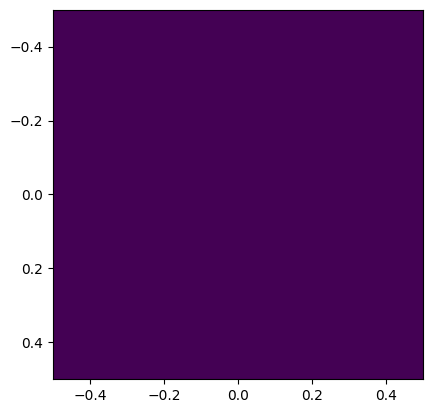

In [ ]:
plt.imshow([[val_image.mean()]])

In [ ]:

inputs = torch.randn(10, 3).to(device)  # 10 samples, 3 features each
encoded_inputs = positional_encoding(inputs, L=6)

torch.Size([10, 39])
